In [3]:
!pip install nltk pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


True

We're using a sample of **IMDB movie reviews** labeled as:
- `1` for Positive reviews
- `0` for Negative reviews

Key characteristics:
- 2000 samples (balanced classes)
- Raw text needs preprocessing

In [ ]:
# Load sample dataset (IMDB reviews sample)
url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
df = pd.read_csv(url, sep='\t', names=['text', 'label'])
df = df.sample(2000, random_state=42)  # Using a subset for faster execution

# Display dataset info
print(f"Dataset shape: {df.shape}")
print("\nLabel distribution:")
print(df['label'].value_counts())
df.head(10)

Dataset shape: (2000, 2)

Label distribution:
label
1    1039
0     961
Name: count, dtype: int64


,text,label
468,overly melodramatic,0
1956,lrb westbrook rrb makes a wonderful subject fo...,1
800,mama africa pretty much delivers on that promise,1
6474,"sad nonsense , this",0
2389,easily the most thoughtful fictional examinati...,1
2647,"tara reid plays a college journalist , but she...",0
5782,"a classy , sprightly spin on film",1
1729,hardly a film that comes along every day,1
5933,"watching this film , one is left with the ines...",1
6558,that ` alabama ' manages to be pleasant in spi...,1


Essential steps to clean text data:
1. **Lowercasing**: Convert all text to uniform case
2. **HTML/URL Removal**: Strip web artifacts
3. **Number Removal**: Digits often don't help sentiment analysis
4. **Punctuation Removal**: !, ? etc. don't carry meaning in BoW
5. **Stopword Removal**: Filter out common words (the, is, etc.)

In [5]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags if any
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Tokenize and remove stopwords
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    return " ".join(words)

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)
df[['text', 'clean_text']].head()

,text,clean_text
468,overly melodramatic,overly melodramatic
1956,lrb westbrook rrb makes a wonderful subject fo...,lrb westbrook rrb makes wonderful subject camera
800,mama africa pretty much delivers on that promise,mama africa pretty much delivers promise
6474,"sad nonsense , this",sad nonsense
2389,easily the most thoughtful fictional examinati...,easily thoughtful fictional examination root c...


How text becomes numbers:
1. **Tokenization**: Split text into words
2. **Vocabulary Creation**: Unique words across all documents
3. **Vectorization**: Each document becomes a vector of word counts

In [6]:
# Create Bag-of-Words features
vectorizer = CountVectorizer(max_features=5000)  # Limit to top 5000 words
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Training samples: 1600
Test samples: 400
Number of features: 5000


Why we use it first:
- Fast training/prediction
- Works well with high-dimensional text data
- Handles sparse BoW vectors effectively

**Mathematics**:  
Applies Bayes' Theorem with "naïve" assumption that features (words) are conditionally independent

Naïve Bayes Classifier Results:
Accuracy: 0.735

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.73       192
           1       0.75      0.74      0.74       208

    accuracy                           0.73       400
   macro avg       0.73      0.73      0.73       400
weighted avg       0.74      0.73      0.74       400



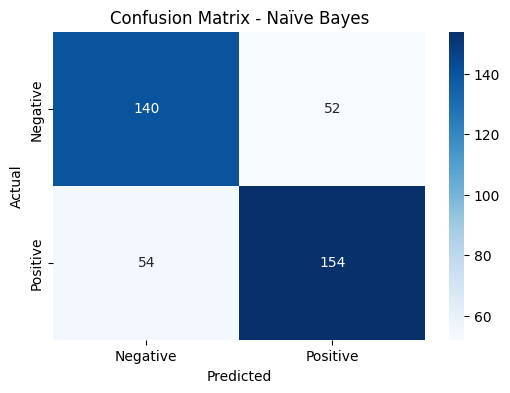

In [7]:
# Train Naïve Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)

# Evaluate
print("Naïve Bayes Classifier Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naïve Bayes')
plt.show()

In [8]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

# Split data
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTF-IDF Representation:")
print(f"Training samples: {X_train_tfidf.shape[0]}")
print(f"Test samples: {X_test_tfidf.shape[0]}")
print(f"Number of features: {X_train_tfidf.shape[1]}")


TF-IDF Representation:
Training samples: 1600
Test samples: 400
Number of features: 5000


## Classifier Comparison

Three algorithms tested on our IMDB sentiment data:

1. **Naïve Bayes**:  
   `A probabilistic classifier that assumes feature independence, ideal for our high-dimensional BoW vectors`  
   - ⚡ Fastest training on our 5000-feature text data  
   - 📊 Works well even with limited training samples  
   - ⚖️ Naturally handles multi-class if extended beyond sentiment  

2. **Logistic Regression**:  
   `A linear model that estimates probability using sigmoid function, effective for our binary sentiment task`  
   - 📈 Learns feature importance (can identify most positive/negative words)  
   - 🎯 Regularization helps prevent overfitting to our text features  
   - 🔍 Can extract coefficients to interpret sentiment drivers  

3. **SVM (Support Vector Machines)**:  
   `Finds the maximum-margin decision boundary between positive/negative reviews`  
   - ✨ Kernel trick helps with non-linear relationships in TF-IDF space  
   - 🛡️ Robust against overfitting in our high-dimensional space  
   - ⏳ Slower but often more accurate than Naïve Bayes for text  


Naïve Bayes with TF-IDF Results:
Accuracy: 0.715
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       192
           1       0.70      0.78      0.74       208

    accuracy                           0.71       400
   macro avg       0.72      0.71      0.71       400
weighted avg       0.72      0.71      0.71       400



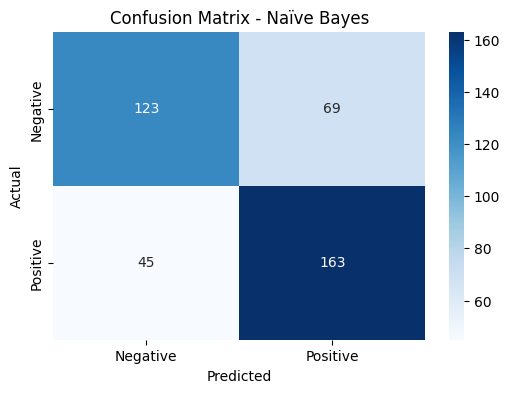


Logistic Regression with TF-IDF Results:
Accuracy: 0.705
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       192
           1       0.70      0.76      0.73       208

    accuracy                           0.70       400
   macro avg       0.71      0.70      0.70       400
weighted avg       0.71      0.70      0.70       400



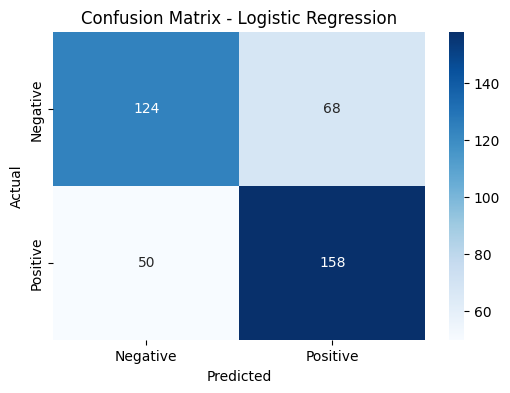


SVM with TF-IDF Results:
Accuracy: 0.7175
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       192
           1       0.71      0.76      0.74       208

    accuracy                           0.72       400
   macro avg       0.72      0.72      0.72       400
weighted avg       0.72      0.72      0.72       400



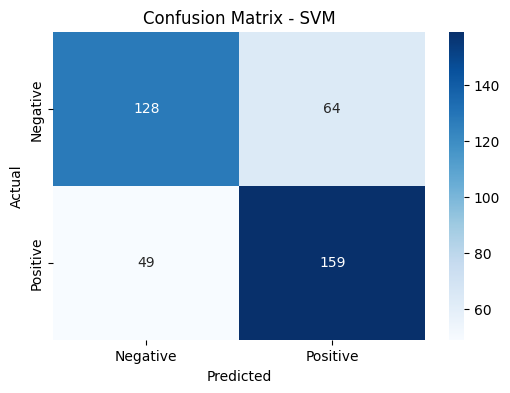

In [9]:
classifiers = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear')
}

for name, clf in classifiers.items():
    # Train classifier
    clf.fit(X_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(X_test_tfidf)
    
    # Evaluate
    print(f"\n{name} with TF-IDF Results:")
    print("Accuracy:", accuracy_score(y_test_tfidf, y_pred))
    print(classification_report(y_test_tfidf, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_tfidf, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

In [10]:
def predict_sentiment(text, model, vectorizer):
    # Preprocess
    clean_text = preprocess_text(text)
    # Transform
    features = vectorizer.transform([clean_text])
    # Predict
    prediction = model.predict(features)
    return "Positive" if prediction[0] == 1 else "Negative"

# Test with sample text
sample_text = "This movie was absolutely fantastic! The acting was superb and the plot was engaging."
print(f"Prediction: {predict_sentiment(sample_text, nb_classifier, vectorizer)}")

sample_text = "I hated every minute of this film. Terrible acting and boring story."
print(f"Prediction: {predict_sentiment(sample_text, nb_classifier, vectorizer)}")

Prediction: Positive
Prediction: Negative


In [ ]:

from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_tfidf, y_train_tfidf)

def predict_sentiment(sentence):
    cleaned = preprocess_text(sentence)
    features = tfidf_vectorizer.transform([cleaned])
    prediction = model.predict(features)[0]
    print("POSITIVE" if prediction == 1 else "NEGATIVE")

predict_sentiment("This movie was fantastic!")

POSITIVE
